# NN hyperparameters opt- Lorenzo Pastore

### Libraries

In [1]:
!apt-get install swig
!pip install smac[all]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-npp-10-1 cuda-npp-dev-10-1 cuda-nsight-10-1
  cuda-nsight-compute-10-1 cuda-nsight-systems-10-1 cuda-nvgraph-10-1
  cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1 cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1
  cuda-nvrtc-dev-10-1 cuda-nvvp-10-1 libnvidia-common-430
  nsight-compute-2019.5.0 nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 6 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5

In [0]:
from smac.facade.func_facade import fmin_smac
from smac.facade.smac_bo_facade import SMAC4BO #Bayesian optimization using a GP 
from smac.facade.smac_hpo_facade import SMAC4HPO
# Import ConfigSpace and different types of parameters
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition
from smac.configspace.util import convert_configurations_to_array

# Import SMAC-utilities
from smac.tae.execute_func import ExecuteTAFuncDict
from smac.scenario.scenario import Scenario
from smac.optimizer.acquisition import EI, PI
from smac.initial_design.initial_design import InitialDesign
from smac.initial_design.random_configuration_design import RandomConfigurations

In [3]:
pip install openml

     |████████████████████████████████| 163kB 2.7MB/s 
  Created wheel for openml: filename=openml-0.10.2-cp36-none-any.whl size=190318 sha256=6f74c10eccd6a0b7144a302e3a38f97eef8528a6c41e757e14724d943d186374
  Stored in directory: /root/.cache/pip/wheels/71/ec/5f/aaad9e184680b0b8f1a02ff0ec640cace5adf5bff7bb0af1b4
  Created wheel for liac-arff: filename=liac_arff-2.4.0-cp36-none-any.whl size=13333 sha256=08f585f358670250332ae7ee5ba1fa15a67d06e5cb0ae5ff8332d35aa688e4ee
  Stored in directory: /root/.cache/pip/wheels/d1/6a/e7/529dc54d76ecede4346164a09ae3168df358945612710f5203
Successfully built openml liac-arff


In [4]:
import numpy as np
import pandas as pd
import openml
from collections import Counter
import matplotlib.pyplot as plt

# Import utilities
import logging
logging.basicConfig(level=logging.INFO)
logging.captureWarnings(capture=True)
logger = logging.getLogger("py.warnings")
handler = logging.StreamHandler()
logger.addHandler(handler)
logger.addFilter(lambda record: "ConvergenceWarning" not in record.getMessage())

# Import sklearn libraries 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

from scipy.stats import uniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

INFO:openml.config:Could not find a configuration file at /root/.openml/config. Going to create an empty file there.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)

  "(https://pypi.org/project/six/).", DeprecationWarning)



In [0]:
seed =np.random.RandomState(123)

## Loading data from OpenML

In [6]:
dataset = openml.datasets.get_dataset(1473)

DEBUG:openml.datasets.dataset:Saved dataset 1473: fertility to file /root/.openml/cache/org/openml/www/datasets/1473/dataset.pkl.py3


In [0]:
x, y, _, _ = dataset.get_data(
    dataset_format='array',
    target=dataset.default_target_attribute
)

# Step 1

The neural network must have 2 hidden layers with 4 units in the first hidden layer and 2 neurons in the second one.
You can set all the other hyperparameters as you prefer (you can use the default values) and optimize the following 2 hyperparameters (HPO):
 - learning rate (numeric in 0.01 - 0.1)
 - momentum (numeric in 0.1 - 0.9)

Choose between Gaussian Process (GP) or Random Forest (RF) as surrogate model.
Use 5 initial random configurations of the hyperparameters as initial design, then perform:
 - 20 iterations of Sequential Model Based Optimization (SMBO) using an acquisition function
 - 20 iterations of SMBO using another acquisition function
Note: the initial design must be the same between the two SMBO experiments related to the different acquisition functions
Compare results against 25 configurations in Grid Search and 25 configurations sampled via Pure Random Search



In [0]:
# Defining HP range
LR_LOWER = 0.01
LR_UPPER = 0.1
MOMENTUM_LOWER = 0.1
MOMENTUM_UPPER = 0.9

# defining learning rate optimization range
learning_rate = UniformFloatHyperparameter("learning_rate_init", 
                                           lower=LR_LOWER,
                                           upper=LR_UPPER)

# defining momentum rate optimization range
momentum = UniformFloatHyperparameter("momentum", 
                                      lower=MOMENTUM_LOWER, 
                                      upper=MOMENTUM_UPPER)

Defining Configuration space and Scenario

In [9]:
# Build Configuration Space
cs = ConfigurationSpace()
cs.add_hyperparameters([learning_rate, momentum])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5]

the initial design must be the same between the two SMBO experiments related to the different acquisition functions

In [0]:
initial_runs = 5
further_runs = 20

In [0]:
# defining 5 random initial configurations (the same for the different experiments
initial_configs = cs.sample_configuration(size = initial_runs)

In [12]:
# defining Scenario 
scenario = Scenario({"run_obj": "quality",
                     "runcount-limit":initial_runs + further_runs,
                     "cs":cs,
                     "deterministic":True})

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-12-09_22:09:24_527576


Using SMAC

In [0]:
def step1_cfg(**cfg):
  smote = SMOTE(random_state=seed)
  mlp = MLPClassifier(hidden_layer_sizes=(4,2,),
                      solver='adam',
                      random_state=seed,
                      **cfg)
  #model_pipeline = make_pipeline(smote, mlp)
  model_pipeline = Pipeline([('smote', smote),
                             ('scaler',StandardScaler()),
                             ('mlp', mlp)])
  return model_pipeline

def step1_scores(kwargs):
  cfg = step1_cfg(**kwargs)
  scores = cross_val_score(cfg, x, y, cv=10)
  return 1-np.mean(scores)  # Min 1-accuracy

res_1 = {}

In [0]:
def run_smac(acquisition_function):
    smac = SMAC4HPO(scenario=scenario,
                    rng=seed,
                    tae_runner=step1_scores,
                    initial_design_kwargs={'configs': initial_configs},
                    acquisition_function=acquisition_function
                    )

    incumbent = smac.optimize()
    bestseen = 1-np.minimum.accumulate(list(
        smac.get_runhistory().cost_per_config.values()
        ))
    res_1[f"HPO - {acquisition_function.__name__}"] = {
    'best': list(incumbent._values.values()),
    'bestseen': bestseen
    }
    return incumbent

Use 5 initial random configurations of the hyperparameters as initial design, then perform:
 - 20 iterations of Sequential Model Based Optimization (SMBO) using an acquisition function
 - 20 iterations of SMBO using another acquisition function
 

In [15]:
# run HPO with Logarithm Expected Improvement as acquisition function
HPO_EI = run_smac(acquisition_function=EI)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 6 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2274) is better than incumbent (0.2463) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.03794526180372212 -> 0.09517546089934852
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7134686282622691 -> 0.41246906300532415
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2203) is better than incumbent (0.2274) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
IN

In [16]:
# run HPO with Probability of improvement as acquisition function
HPO_PI = run_smac(acquisition_function=PI)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 6 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (0.1879) is better than incumbent (0.2283) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.03794526180372212 -> 0.09517546089934852
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.7134686282622691 -> 0.41246906300532415
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.1879
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent

## GridSearch 

In [0]:
model_pipeline = step1_cfg()

In [0]:
# Defining parameter's range
lr_range = np.linspace(LR_LOWER, LR_UPPER, 5)
momentum_range = np.linspace(MOMENTUM_LOWER, MOMENTUM_UPPER, 5)
# Defining parameter's search space
grid_params = {'mlp__learning_rate_init': lr_range,
               'mlp__momentum': momentum_range}

In [19]:
GS = GridSearchCV(estimator=model_pipeline,
                  param_grid=grid_params,
                  cv=10,
                  verbose=1)

GS_RES = GS.fit(x,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   24.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

  DeprecationWarning)



In [0]:
prog_GS = GS.cv_results_['mean_test_score']
best_GS = list(GS.best_params_.values())
bestseen_GS = np.maximum.accumulate(prog_GS)

res_1['GRID SEARCH'] = {'best': best_GS,
                        'bestseen': bestseen_GS}

## Random Search

In [0]:
# Defining parameter's range
lr_dist = uniform(LR_LOWER, LR_UPPER - LR_LOWER)
lr_dist.random_state = seed

mom_dist = uniform(MOMENTUM_LOWER, MOMENTUM_UPPER - MOMENTUM_LOWER)
mom_dist.random_state = seed

random_params = {'mlp__learning_rate_init': lr_dist,
                 'mlp__momentum': mom_dist}

In [22]:
RS = RandomizedSearchCV(estimator=model_pipeline,
                        param_distributions=random_params,
                        n_iter=25,
                        cv=10,
                        verbose =1,
                        random_state=seed)

RS_RES = RS.fit(x,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   23.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)

  DeprecationWarning)



In [0]:
prog_RS = RS.cv_results_['mean_test_score']
best_RS = list(RS.best_params_.values())
bestseen_RS = np.maximum.accumulate(prog_RS)

res_1['RANDOM SEARCH'] = {'best': best_RS,
                          'bestseen': bestseen_RS}

# Step 1 - Result comparison

In [0]:
# plot the evolution of "bestseen" config 
def plot_bestseen(dic, runs):
  x_ax = np.arange(runs)
  plt.figure(figsize=(15, 8))
  ax = plt.subplot(111)
  for alg in dic:
    ax.plot(x_ax, dic[alg]['bestseen'],'-o', label=alg)
  ax.legend(loc='upper center', 
            bbox_to_anchor=(0.5, -0.08), 
            shadow=True, 
            ncol=2)
  plt.title('Best Seen')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.show()

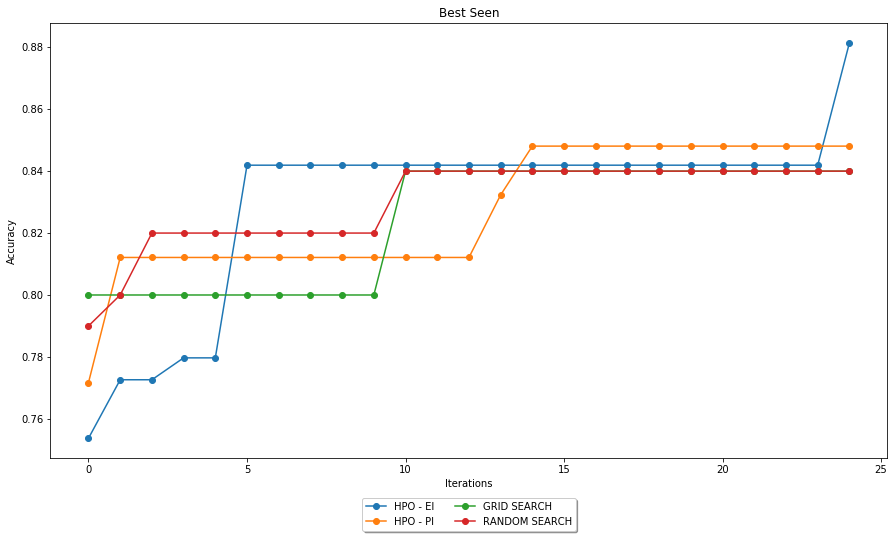

In [25]:
plot_bestseen(res_1, runs=initial_runs + further_runs )

In [26]:
print('Expected Improvement -> Learning rate:',res_1['HPO - EI']['best'][0],'Momentum:',res_1['HPO - EI']['best'][1])
print('Probability of Improvement -> Learning rate:',res_1['HPO - PI']['best'][0],'Momentum:',res_1['HPO - PI']['best'][1])
print('Random Search -> Learning rate:',res_1['RANDOM SEARCH']['best'][0],'Momentum:',res_1['RANDOM SEARCH']['best'][1])
print('Grid Search -> Learning rate:',res_1['GRID SEARCH']['best'][0],'Momentum:',res_1['GRID SEARCH']['best'][1])

Expected Improvement -> Learning rate: 0.09811455703036868 Momentum: 0.8850511045952261
Probability of Improvement -> Learning rate: 0.08458538137576717 Momentum: 0.7114212227495175
Random Search -> Learning rate: 0.08306333640277833 Momentum: 0.3693024741584735
Grid Search -> Learning rate: 0.05500000000000001 Momentum: 0.1


# Step 2

In this step use SMBO to optimize, along with the two previous hyper-parameters, the number of units in the two hidden layers. Number of units ranges in 1 to 5 for both the two hidden layers
In this case use RF and expand the budget as follows:
 - 10 initial configurations randomly chosen (initial design)
 - 100 iterations of SMBO using an acquisition function
 - 100 iterations of SMBO using another acquisition function
Note: as in the previous step, the initial design must be the same between the two SMBO experiments related to the different acquisition functions

In this case is not required any comparison with Grid Search and Random Search.

In [0]:
# defining learning rate optimization range
learning_rate = UniformFloatHyperparameter("learning_rate_init", 
                                           lower=LR_LOWER,
                                           upper=LR_UPPER)

# defining momentum rate optimization range
momentum = UniformFloatHyperparameter("momentum", 
                                      lower=MOMENTUM_LOWER, 
                                      upper=MOMENTUM_UPPER)

# defining first layer optimization range
neurons_layer_1 = UniformIntegerHyperparameter("neurons_1", 1,5)
neurons_layer_2 = UniformIntegerHyperparameter("neurons_2", 1,5)

In [28]:
# Build Configuration Space
cs_2 = ConfigurationSpace()
cs_2.add_hyperparameters([learning_rate, momentum,neurons_layer_1,neurons_layer_2])

[learning_rate_init, Type: UniformFloat, Range: [0.01, 0.1], Default: 0.055,
 momentum, Type: UniformFloat, Range: [0.1, 0.9], Default: 0.5,
 neurons_1, Type: UniformInteger, Range: [1, 5], Default: 3,
 neurons_2, Type: UniformInteger, Range: [1, 5], Default: 3]

In [0]:
initial_runs2 = 10
further_runs2 = 100

In [30]:
# defining 5 random initial configurations (the same for the different experiments)
initial_configs2 = cs_2.sample_configuration(size = initial_runs2)

# defining Scenario to maximize accuracy
scenario_2 = Scenario({"run_obj": "quality",
                       "runcount-limit":initial_runs2 + further_runs2,
                       "cs":cs_2,
                       "deterministic":True})

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2019-12-09_22:11:27_098121


using Smac

In [0]:
def step2_cfg(cfg):
  smote = SMOTE(random_state=seed)
  mlp = MLPClassifier(hidden_layer_sizes=(cfg['neurons_1'],cfg['neurons_2'],),
                      solver='adam',
                      random_state=seed,
                      learning_rate_init=cfg['learning_rate_init'],
                      momentum =cfg['momentum'])
  model_pipeline = Pipeline([('smote', smote),
                             ('scaler',StandardScaler()),
                             ('mlp', mlp)])
  scores = cross_val_score(model_pipeline, x, y, cv=10)
  return 1-np.mean(scores)  # Min 1-accuracy

res_2 = {}

In [0]:
def run_smac2(acquisition_function):
      smac = SMAC4HPO(scenario=scenario_2, 
                     rng=seed,
                     tae_runner=step2_cfg,
                     initial_design_kwargs={'configs': initial_configs2},
                     acquisition_function=acquisition_function
                     )
      incumbent = smac.optimize()
      bestseen = 1-np.minimum.accumulate(list(
      smac.get_runhistory().cost_per_config.values()))
      res_2[f"HPO - {acquisition_function.__name__}"] = {
          'best': list(incumbent._values.values()),
          'bestseen': bestseen
          }
      return incumbent

In [33]:
# run HPO with Logarithm Expected Improvement as acquisition function
HPO_EI_2 = run_smac2(acquisition_function=EI)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 27 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2196) is better than incumbent (0.2274) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.09969943627563377 -> 0.0438138948308998
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.1914682852256549 -> 0.6037255147591134
INFO:smac.intensification.intensification.Intensifier:Challenger (0.1386) is better than incumbent (0.2196) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INF

In [34]:
# run HPO with Probability of improvement as acquisition function
HPO_PI_2 = run_smac2(acquisition_function=PI)

INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.sobol_design.SobolDesign:Running initial design for 27 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.intensification.intensification.Intensifier:Challenger (0.2679) is better than incumbent (0.2722) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  learning_rate_init : 0.09969943627563377 -> 0.038532534543347804
INFO:smac.intensification.intensification.Intensifier:  momentum : 0.1914682852256549 -> 0.5725853643722799
INFO:smac.intensification.intensification.Intensifier:  neurons_1 : 4 -> 1
INFO:smac.intensification.intensification.Intensifier:  neurons_2 : 3 -> 4
INFO:smac.intensification.intensification.Inte

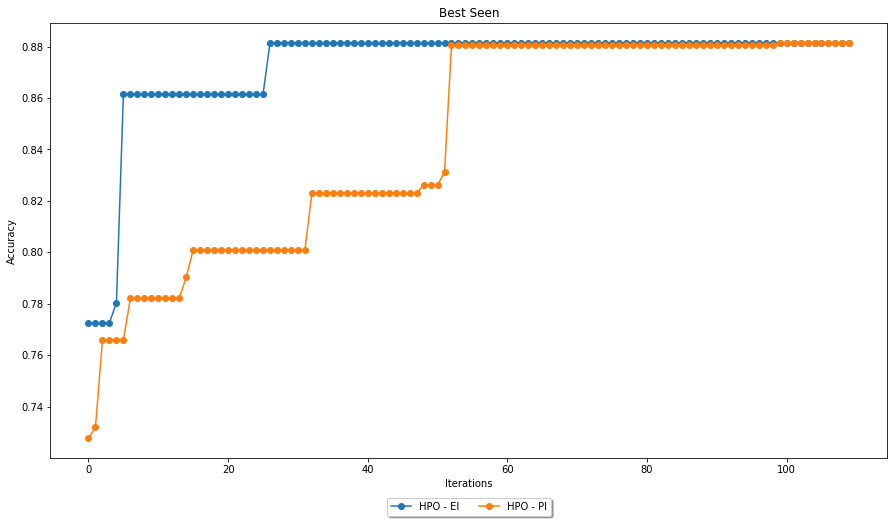

In [35]:
plot_bestseen(res_2, runs=initial_runs2 + further_runs2 )

In [36]:
print('Expected Improvement -> Learning rate:',res_2['HPO - EI']['best'][0],'Momentum:',res_2['HPO - EI']['best'][1])
print('Probability of Improvement -> Learning rate:',res_2['HPO - PI']['best'][0],'Momentum:',res_2['HPO - PI']['best'][1]) 

Expected Improvement -> Learning rate: 0.04454725835007655 Momentum: 0.6950744055680251
Probability of Improvement -> Learning rate: 0.06699994497637488 Momentum: 0.45733799180833257
